
# Colab 서버 스펙 확인


In [1]:
# CPU 스펙
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [2]:
# 메모리 스펙
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10725056 kB
MemAvailable:   12507320 kB
Buffers:           71528 kB
Cached:          1869208 kB
SwapCached:            0 kB
Active:           697468 kB
Inactive:        1664524 kB
Active(anon):     400288 kB
Inactive(anon):      308 kB
Active(file):     297180 kB
Inactive(file):  1664216 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               184 kB
Writeback:             0 kB
AnonPages:        421276 kB
Mapped:           221824 kB
Shmem:               904 kB
Slab:             159120 kB
SReclaimable:     123532 kB
SUnreclaim:        35588 kB
KernelStack:        3428 kB
PageTables:         5208 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2515204 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [ ]:
# OS 확인
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [ ]:
# Python 버전 확인
!python --version

Python 3.6.9


# 구현

## 필요한 라이브러리 로드

In [3]:
# 참고자료와 코드:
# 1.https://blog.csdn.net/qq_38612955/article/details/82564225?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522159061408519724839220561%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fblog.%2522%257D&request_id=159061408519724839220561&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~blog~first_rank_v1~rank_blog_v1-4-82564225.pc_v1_rank_blog_v1&utm_term=%E6%83%85%E6%84%9F+%E7%BD%91%E7%9B%98
# 2.https://blog.csdn.net/wx740851326/article/details/101533167
# 3.실습6
# 4.https://kknews.cc/tech/4jpbpgg.html

import pandas as pd

import re
import nltk
import numpy as np 
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense ,Embedding,Activation
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences  
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## 데이터 다운로드



In [4]:
# 데이터 다운로드
!git clone https://github.com/YoonHan/COSE461-Team-14.git

Cloning into 'COSE461-Team-14'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 59 (delta 15), reused 46 (delta 7), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [5]:
# Training Dataset 로딩
data = pd.read_csv('/content/COSE461-Team-14/Friends/friends_train.csv',encoding='utf-8')
totalText = data['utterance']
display(totalText)

0        also I was the point person on my companys tr...
1                         You mustve had your hands full.
2                                  That I did. That I did.
3            So lets talk a little bit about your duties.
4                                   My duties?  All right.
                               ...                        
10556                                           You or me?
10557    I got it. Uh, Joey, women don't have Adam's ap...
10558                 You guys are messing with me, right?
10559                                                Yeah.
10560    That was a good one. For a second there, I was...
Name: utterance, Length: 10561, dtype: object

## 데이터 전처리

In [6]:
# 전처리 :
# 대문자를 소문자로 전환 &
# Additional character제거
for i in totalText:
    i = i.lower()
    re.split(r' ',i)
    r = u'[0-9’!"#$%&\'()*+,-./:;<=>?@]+'
    i = re.sub(r,'',i)

# 전처리 : 
# 더 편하게 처리하기 위해서 emotion label에 있는 문자를 숫자로 전환 
tempLabel = data['emotion']
status_dict = tempLabel.unique().tolist()
data['transfromed'] = tempLabel.apply(lambda x : status_dict.index(x))
totalLabel = data['transfromed']
display(totalLabel)

# Test Dataset 로딩
data1 = pd.read_csv('/content/COSE461-Team-14/Friends/en_data.csv',encoding='utf-8')   
testText = data1['utterance']
for i in totalText:
    i=i.lower()
    re.split(r' ',i)
    r = u'[0-9’!"#$%&\'()*+,-./:;<=>?@]+'
    i = re.sub(r,'',i)

# 데이터 크기정보 출력
display(len(totalText))
display(len(totalLabel))
display(len(testText))

0        0
1        0
2        0
3        0
4        1
        ..
10556    0
10557    3
10558    1
10559    0
10560    3
Name: transfromed, Length: 10561, dtype: int64

10561

10561

3296

In [7]:
# 전처리 :
# Tokenizer를 이용해서 문장을 sequence로 전환 
train_tokenizer = Tokenizer()
train_tokenizer.fit_on_texts(totalText)
train_sequences = train_tokenizer.texts_to_sequences(totalText)
test_sequences = train_tokenizer.texts_to_sequences(testText)

# 모든 tokens의 길이 얻기
num_tokens = [ len(tokens) for tokens in train_sequences ]
num_tokens = np.array(num_tokens)

# tokens의 평균 길이
print('mean',np.mean(num_tokens))
# 제일 긴 tokens의 길이
print('max',np.max(num_tokens))
# 제일 잛은 tokens의 길이
print('min',np.min(num_tokens))

mean 7.894801628633652
max 69
min 0


In [8]:
# 최대 token의 개수 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print('max tokens :', max_tokens)
# max_tokens 가 데이터 전체에 대한 token 수 보다 많은지 체크
a = np.sum( num_tokens < max_tokens ) / len(num_tokens)
print(a)

# 벡터화된 문장에 padding 처리. 
# 그 이후, 각 문장의 길이가 다르기 때문에  
# 길이가 지정 되지않은 문장을 0로 채우기  
# 문장 길이가 지정한 길이를 초과하면 cropping 하기
train_Data = sequence.pad_sequences(train_sequences,maxlen=69)
test_Data = sequence.pad_sequences(test_sequences,maxlen=69)

# Training Dataset & Test Dataset 크기 확인
print(train_Data.shape)
print(test_Data.shape)
print(train_Data)
train_label = to_categorical(totalLabel,8)
print(train_label.shape)
print(train_label)

# label 변환하기 
# multi-class classification task는 binary classification task와 비슷하여
# categorical variable 의 output를 metric variable로 전환해야함.
# one hot encoding 방식을 사용하여 output은 label있는 존재하는 위치가 1이 되고 나머지는 0이 됨.
# Ex) 0:[0,0,0,0,0,0,0,0] 5:[0,0,0,0,0,5,0,0] 1:[0,1,0,0,0,0,0,0]
train_label = to_categorical(totalLabel,8)
print(train_label.shape)
print(train_label)

# Dataset을 train set과 test set으로 나누기
X_train, X_test, y_train, y_test = train_test_split(train_Data , train_label, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

max tokens : 20
0.9422403181516902
(10561, 69)
(3296, 69)
[[   0    0    0 ... 2888  905  906]
 [   0    0    0 ...   40  709  827]
 [   0    0    0 ...    9    1   73]
 ...
 [   0    0    0 ...   36   14   34]
 [   0    0    0 ...    0    0   17]
 [   0    0    0 ...   35   42  177]]
(10561, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10561, 8)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(7920, 69)
(2641, 69)
(7920, 8)
(2641, 8)


## 데이터 EDA

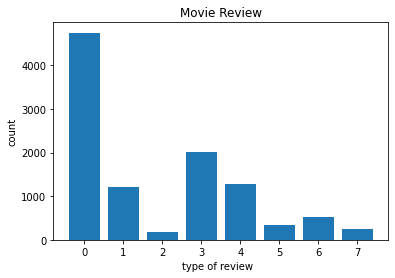

In [ ]:
# label emotion분포보기 
uniqueLabel=set(totalLabel)
x=[]
y=[]
for i in uniqueLabel:
    x.append(i)
    y.append(totalLabel[totalLabel==i].size)
plt.figure(111)
plt.bar(x,y)
plt.xlabel('type of review  ')
plt.ylabel('count')
plt.title('Movie Review')
plt.show()

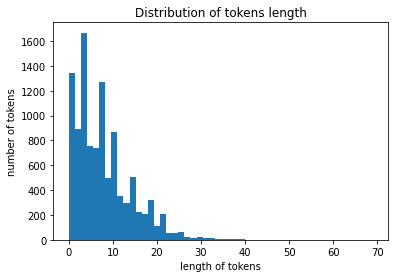

In [ ]:
# train dataset길이 보기 
plt.hist((num_tokens), bins = 50)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

## 모델 정의

In [9]:
# keras를 이용해서 LTSM 빌드 
max_features = len(train_tokenizer.index_word)
# padding = max_tokens
max_len = 69 
# 훈련 횟수 정의
epochs = 50 
# embedding layer의 차원수
emb_dim = 128 
# batch 크기 
batch_size=80   

# 모델 정의 부분
model = Sequential()
model.add(Embedding(max_features+1,emb_dim,mask_zero=True))
model.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test,y_test))
model.evaluate(X_test,y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         777984    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
Total params: 840,072
Trainable params: 840,072
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7920 samples, validate on 2641 samples
Epoch 1/50
7920/7920 [==============================] - 20s 2ms/step - loss: 1.7879 - accuracy: 0.4447 - val_loss: 1.6304 - val_accuracy: 0.4536
Epoch 2/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.6159 - accuracy: 0.4513 - val_loss: 1.5614 - val_accuracy: 0.4566
Epoch 3/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.5276 - accuracy: 0.4705 - val_loss: 1.5288 - val_accuracy: 0.4665
Epoch 4/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.4285 - accuracy: 0.4986 - val_loss: 1.5298 - val_accuracy: 0.4589
Epoch 5/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.3162 - accuracy: 0.5429 - val_loss: 1.5320 - val_accuracy: 0.4699
Epoch 6/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.2106 - accuracy: 0.5917 - val_loss: 1.5601 - val_accuracy: 0.4623
Epoch 7/50
7920/7920 [==============================] - 18s 2ms/step - loss: 1.112

[2.6622256030191394, 0.43657705187797546]

## 예측 및 결과 파일 생성

In [ ]:
predict = model.predict_classes(test_Data)
result = pd.read_csv('/content/COSE461-Team-14/Friends/en_sample.csv')
result['Expected'] = predict
# Expected label를 전처리 때 사용했던 양식으로 전환
result['Expected']= result['Expected'].apply(lambda x : status_dict[x])
# write to result file 
result.to_csv('./en_prediction.csv', index=False)

In [ ]:
# 예측 결과 파일 다운로드용 라이브러리
from google.colab import files
files.download('./en_prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>